Epoch [1/10], Train Loss: 0.3412, Train Accuracy: 86.90%, Val Accuracy: 92.90%, F1 Score: 0.93, Precision: 0.95, Recall: 0.93
Epoch [2/10], Train Loss: 0.0931, Train Accuracy: 96.70%, Val Accuracy: 98.80%, F1 Score: 0.99, Precision: 0.99, Recall: 0.99
Epoch [3/10], Train Loss: 0.0331, Train Accuracy: 98.80%, Val Accuracy: 98.00%, F1 Score: 0.98, Precision: 0.98, Recall: 0.98
Epoch [4/10], Train Loss: 0.0496, Train Accuracy: 98.50%, Val Accuracy: 99.50%, F1 Score: 0.99, Precision: 1.00, Recall: 0.99
Epoch [5/10], Train Loss: 0.0070, Train Accuracy: 99.78%, Val Accuracy: 92.40%, F1 Score: 0.92, Precision: 0.94, Recall: 0.92
Epoch [6/10], Train Loss: 0.0355, Train Accuracy: 98.95%, Val Accuracy: 99.10%, F1 Score: 0.99, Precision: 0.99, Recall: 0.99
Epoch [7/10], Train Loss: 0.0483, Train Accuracy: 98.65%, Val Accuracy: 99.40%, F1 Score: 0.99, Precision: 0.99, Recall: 0.99
Epoch [8/10], Train Loss: 0.0365, Train Accuracy: 99.00%, Val Accuracy: 99.30%, F1 Score: 0.99, Precision: 0.99, Recal

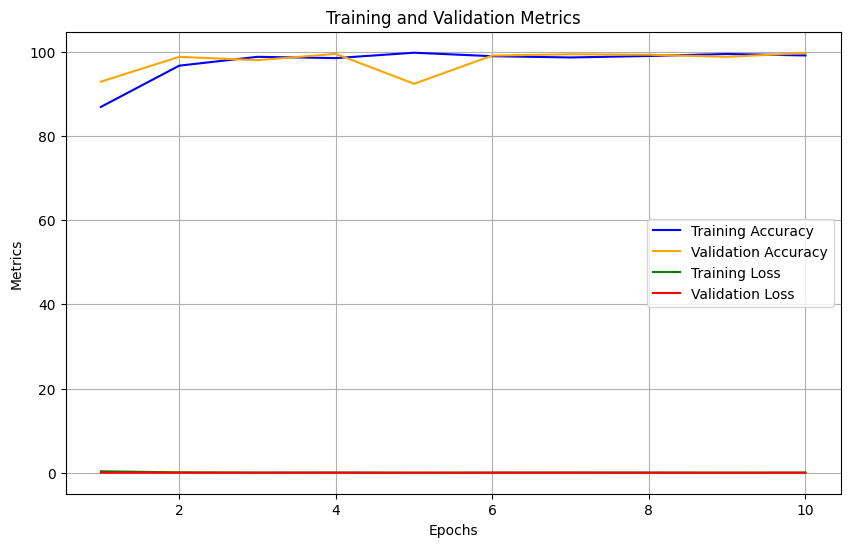

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup using Swin Transformer Base
model = create_model('swin_base_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and evaluation
num_epochs = 10
train_losses = []
train_accuracies = []  
val_accuracies = []
val_losses = []
val_f1_scores = []
val_precisions = []
val_recalls = []
best_val_accuracy = 0.0
best_model_path = 'swin_b_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)

    val_loss = criterion(outputs, labels)
    val_losses.append(val_loss.item())

    # Calculate F1 score, precision, and recall
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')

    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'F1 Score: {val_f1:.2f}, '
          f'Precision: {val_precision:.2f}, '
          f'Recall: {val_recall:.2f}')

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)

# Plotting
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

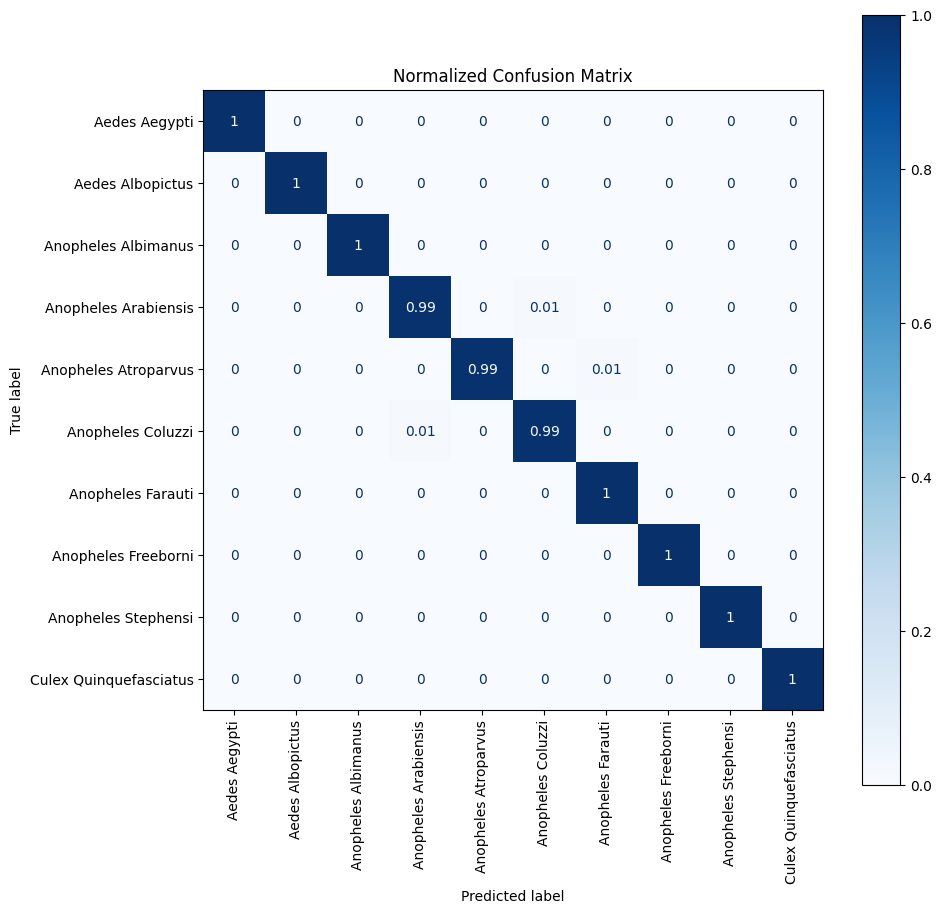

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming the completion of the training and validation phase
# and you have `all_labels` and `all_preds`

# Define class names manually based on your dataset
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()


In [6]:
from timm import create_model

# Model setup using Swin Transformer Base
model = create_model('swin_base_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters())

# Convert the number of parameters to millions
num_params_millions = num_params / 1_000_000

print(f"Number of parameters in the model: {num_params_millions:.2f} million")


Number of parameters in the model: 86.75 million
